# Import Library
Import library yang dibutuhkan

In [102]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import average_precision_score, ndcg_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Data Loading
Download data dari kagle menggunakan API dan membacanya

In [103]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"asgarindoo","key":"d2ada975d372160111ad3369a5dadc28"}'}

In [104]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle

!kaggle datasets download -d arashnic/book-recommendation-dataset

!unzip -q book-recommendation-dataset.zip -d book_dataset


Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
book-recommendation-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace book_dataset/Books.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [105]:
books = pd.read_csv('book_dataset/Books.csv', encoding='latin-1')
users = pd.read_csv('book_dataset/Users.csv', encoding='latin-1')
ratings = pd.read_csv('book_dataset/Ratings.csv', encoding='latin-1')

books.head()

<ipython-input-105-040f64e94a7d>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('book_dataset/Books.csv', encoding='latin-1')


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


Mengecek jumlah data

In [106]:
print('jumlah data buku: ', len(books.index))
print('jumlah data pengguna: ', len(users.index))
print('jumlah data rating: ', len(ratings.index))

jumlah data buku:  271360
jumlah data pengguna:  278858
jumlah data rating:  1149780


# Univariate Exploratory Data Analysis

Tahap eksplorasi data penting untuk memahami karakteristik masing-masing variabel dalam dataset, serta membantu menentukan pendekatan pemodelan yang sesuai. Proses ini mencakup analisis terhadap tipe data, jumlah nilai unik, serta distribusi dari setiap variabel.

Dataset rekomendasi buku terdiri dari tiga variabel utama:
  - books : berisi informasi terkait buku seperti judul, penulis, dan tahun terbit.
  - users : berisi informasi profil pengguna seperti usia dan lokasi.
  - ratings : berisi data rating yang diberikan oleh pengguna terhadap buku



### Variabel Books
Variabel books berisi metadata dari buku-buku yang ada dalam sistem

#### cek struktur data

In [107]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


berdasarkan output diatas terdapat 271.360 entri dan 8 kolom

#### Rangkuman Statistik

In [108]:
books.describe(include='all')

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271358,271360,271358,271360,271360,271357
unique,271360,242135,102022,202,16807,271044,271044,271041
top,020130998X,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/042509474X.0...,http://images.amazon.com/images/P/042509474X.0...,http://images.amazon.com/images/P/006091985X.0...
freq,1,27,632,13903,7535,2,2,2


#### Cek masing masing kolom

In [109]:
print('Banyak data: ', books.index.stop)
print('Kolom pada data buku:\n', books.columns)

Banyak data:  271360
Kolom pada data buku:
 Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')


In [110]:
print(books['ISBN'].nunique())
print(books['ISBN'].value_counts())

271360
ISBN
020130998X    1
0130897930    1
1874166633    1
3596156904    1
3257217323    1
             ..
0393045218    1
0374157065    1
0060973129    1
0002005018    1
0195153448    1
Name: count, Length: 271360, dtype: int64


ISBN harusnya unik. Berdasarkan output diatas tidak ada ISBN yang tidak unik atau duplikat.

242135


<Axes: ylabel='Book-Title'>

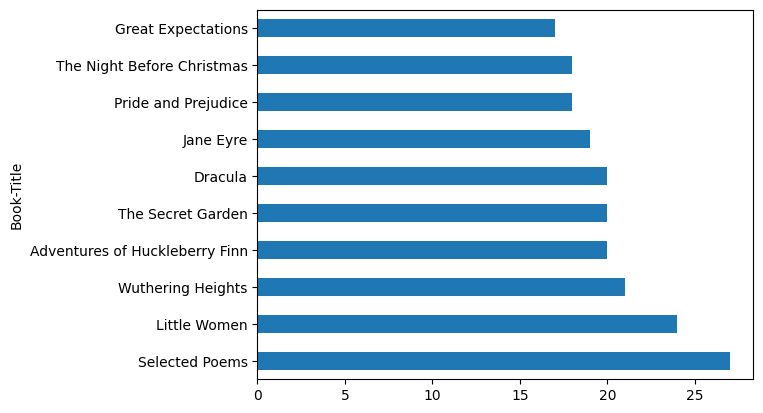

In [111]:
print(books['Book-Title'].nunique())
books['Book-Title'].value_counts().head(10).plot(kind='barh')

Melihat buku yang paling banyak muncul (top duplicate data)

count     271360
unique       202
top         2002
freq       13903
Name: Year-Of-Publication, dtype: int64


<Axes: xlabel='Year-Of-Publication'>

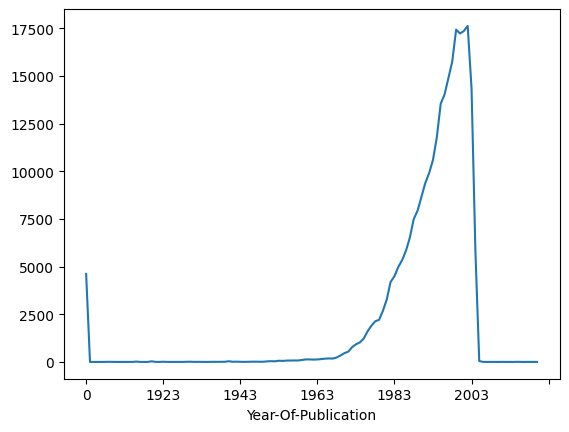

In [112]:
print(books['Year-Of-Publication'].describe())
books['Year-Of-Publication'].astype(str).value_counts().sort_index().plot(kind='line')

mengecek distribusi tahun publikasi,jika data ada tahun < 1900 atau > 2025 (outlier) itu perlu dibersihkan

<Axes: ylabel='Publisher'>

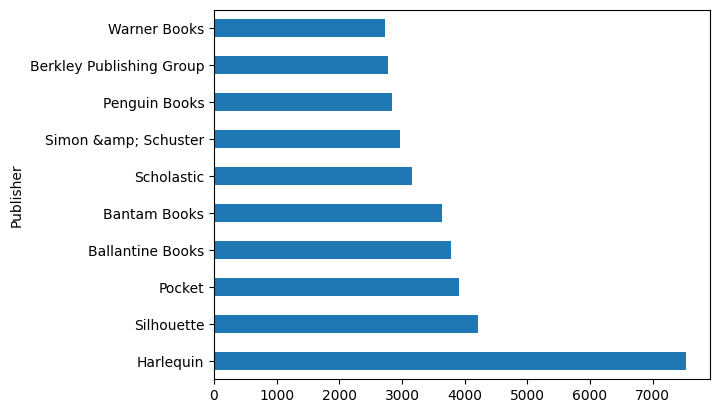

In [113]:
books['Publisher'].value_counts().head(10).plot(kind='barh')

Penerbit paling aktif

### Variabel Users
Variabel users berisi informasi pengguna

#### Cek struktur data

In [114]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


#### Rangkuman statistik

In [115]:
users.describe(include="all")

,User-ID,Location,Age
count,278858.00000,278858,168096.000000
unique,NaN,57339,NaN
top,NaN,"london, england, united kingdom",NaN
freq,NaN,2506,NaN
mean,139429.50000,NaN,34.751434
std,80499.51502,NaN,14.428097
min,1.00000,NaN,0.000000
25%,69715.25000,NaN,24.000000
50%,139429.50000,NaN,32.000000
75%,209143.75000,NaN,44.000000


#### Cek masing masing kolom

In [116]:
print('Banyak data: ', users.index.stop)
print('Kolom pada data users:\n', users.columns)

Banyak data:  278858
Kolom pada data users:
 Index(['User-ID', 'Location', 'Age'], dtype='object')


In [117]:
print("Jumlah User-ID unik:", users['User-ID'].nunique())
print(users['User-ID'].value_counts())

Jumlah User-ID unik: 278858
User-ID
278858    1
1         1
2         1
3         1
4         1
         ..
15        1
14        1
13        1
12        1
11        1
Name: count, Length: 278858, dtype: int64


<Axes: ylabel='Location'>

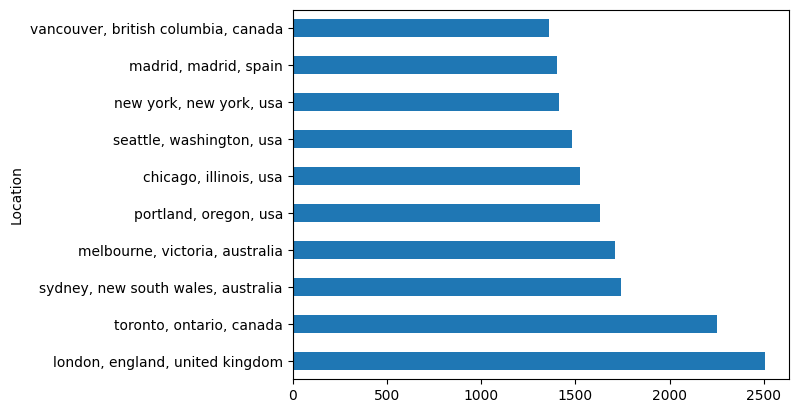

In [118]:
users['Location'].value_counts().head(10).plot(kind='barh')

- Lokasi bisa diekstrak menjadi 3 bagian: kota, provinsi, dan negara
- Banyak data bisa berasal dari satu negara, dan bisa digunakan untuk analisis geografi

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64


<Axes: >

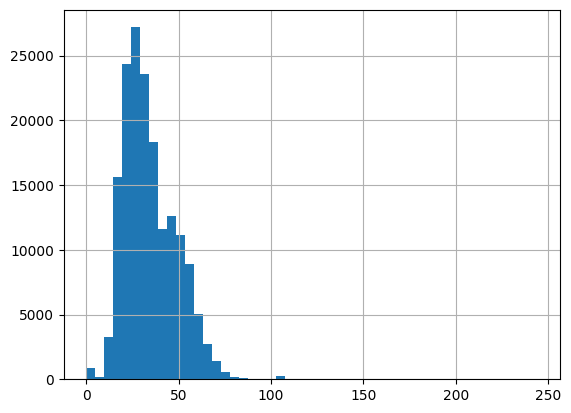

In [119]:
print(users['Age'].describe())
users['Age'].hist(bins=50)

### Variabel Ratings

Variabel ratings adalah inti dari sistem rekomendasi akan di bangun. Data ini menunjukkan penilaian yang diberikan oleh pengguna terhadap suatu buku

#### Cek struktur data

In [120]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


#### Rangkuman statistik

In [121]:
ratings.describe(include="all")

,User-ID,ISBN,Book-Rating
count,1.149780e+06,1149780,1.149780e+06
unique,NaN,340556,NaN
top,NaN,0971880107,NaN
freq,NaN,2502,NaN
mean,1.403864e+05,NaN,2.866950e+00
std,8.056228e+04,NaN,3.854184e+00
min,2.000000e+00,NaN,0.000000e+00
25%,7.034500e+04,NaN,0.000000e+00
50%,1.410100e+05,NaN,0.000000e+00
75%,2.110280e+05,NaN,7.000000e+00


In [122]:
print('Banyak data: ', ratings.index.stop)
print('Kolom pada data rating:\n', ratings.columns)

Banyak data:  1149780
Kolom pada data rating:
 Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')


Jumlah user unik: 105283


<Axes: ylabel='User-ID'>

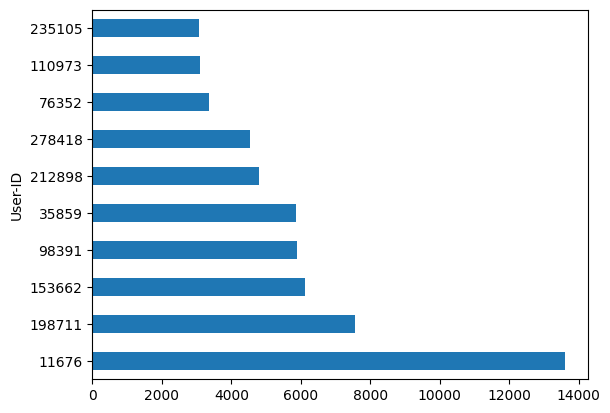

In [123]:
print("Jumlah user unik:", ratings['User-ID'].nunique())
ratings['User-ID'].value_counts().head(10).plot(kind='barh')

Melihat seberapa aktif user dalam memberikan rating

Jumlah ISBN unik: 340556


<Axes: ylabel='ISBN'>

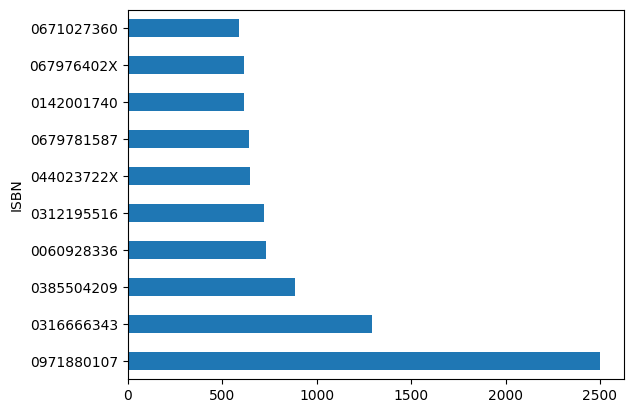

In [124]:
print("Jumlah ISBN unik:", ratings['ISBN'].nunique())
ratings['ISBN'].value_counts().head(10).plot(kind='barh')

distribusi rating pada jumlah buku

count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: Book-Rating, dtype: float64


<Axes: xlabel='Book-Rating'>

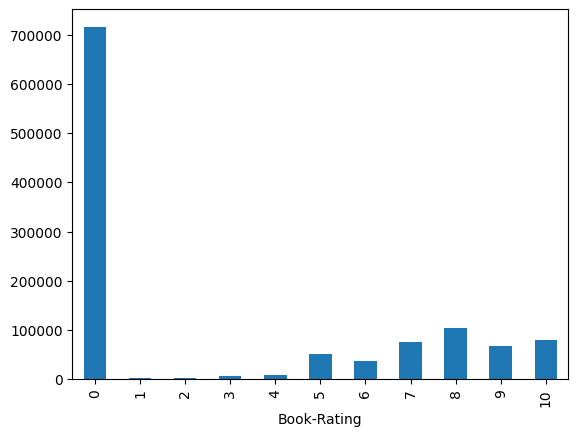

In [125]:
print(ratings['Book-Rating'].describe())
ratings['Book-Rating'].value_counts().sort_index().plot(kind='bar')

- Nilai 0 berarti implicit rating (user melihat buku tapi tidak memberikan penilaian eksplisit).
- Nilai 1–10 adalah explicit rating.



# Data Preprocessing

Melakukan pembersihan dan penggabungan data dari beberapa sumber untuk memastikan data yang digunakan bersih, relevan, dan siap untuk proses modeling. Langkah-langkahnya mencakup penghapusan data kosong, duplikat, nilai tidak valid, serta penyatuan data ke dalam satu set yang konsisten

#### Preprocessing books Variable

cek nilai kosong (missing value)

In [126]:
books.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,2
Year-Of-Publication,0
Publisher,2
Image-URL-S,0
Image-URL-M,0
Image-URL-L,3


berdasarkan output diatas, terdapat nilai kosong di beberapa kolom variabel buku

membersihkan nilai kosong (missing value)

In [127]:
books = books.dropna(subset=['Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-L'])
books.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,0
Year-Of-Publication,0
Publisher,0
Image-URL-S,0
Image-URL-M,0
Image-URL-L,0


drop kolom image karena gambar tidak digunakan untuk modeling

In [128]:
books = books.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'])

cek judul buku yang duplikat

In [129]:
print("Jumlah judul buku yang duplikat:", books['Book-Title'].duplicated().sum())

duplicate_title_counts = books['Book-Title'].value_counts()
duplicate_titles = duplicate_title_counts[duplicate_title_counts > 1]

duplicate_books = books[books['Book-Title'].isin(duplicate_titles.index)][['Book-Title', 'ISBN']]

duplicate_books_unique = duplicate_books.drop_duplicates(subset='Book-Title')

duplicate_books_unique = duplicate_books_unique.merge(
    duplicate_titles.rename('Jumlah Duplikat'),
    left_on='Book-Title',
    right_index=True
)

duplicate_books_unique = duplicate_books_unique.sort_values(by='Jumlah Duplikat', ascending=False)
duplicate_books_unique.head(20)

Jumlah judul buku yang duplikat: 29224


,Book-Title,ISBN,Jumlah Duplikat
4523,Selected Poems,081120958X,27
3952,Little Women,185854176X,24
993,Wuthering Heights,0553212583,21
2959,Dracula,156619301X,20
3759,The Secret Garden,0812505018,20
2354,Adventures of Huckleberry Finn,0835902242,20
3323,Jane Eyre,0451518845,19
41,Pride and Prejudice,055321215X,18
8951,The Night Before Christmas,0505523183,18
7610,Great Expectations,0689839618,17


membersihkan buku yang duplikat

In [130]:
books = books.drop_duplicates(subset='Book-Title', keep='first')
print("Jumlah judul buku yang duplikat:", books['Book-Title'].duplicated().sum())

Jumlah judul buku yang duplikat: 0


Mengubah tipe data tahun publikasi ke int dan membersihkan outlier

In [131]:
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)
books = books[(books['Year-Of-Publication'] > 1900) & (books['Year-Of-Publication'] <= 2025)]

In [132]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 238197 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 238197 non-null  object
 1   Book-Title           238197 non-null  object
 2   Book-Author          238197 non-null  object
 3   Year-Of-Publication  238197 non-null  int64 
 4   Publisher            238197 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.9+ MB


#### Preprocessing Users Variable

cek nilai kosong (missing value) data umur

In [133]:
users['Age'].isnull().sum()

np.int64(110762)

membersihkan nilai kosong dan (outlier jika ada) data umur

In [134]:
users['Age'] = users['Age'].fillna(0).astype(int)

In [135]:
users = users[(users['Age'] >= 13) & (users['Age'] <= 80)]

memisahkan fitur lokasi menjadi tiga bagian

In [136]:
users[['City', 'State', 'Country']] = users['Location'].str.split(',', expand=True, n=2)
users['Country'] = users['Country'].str.strip()
users = users.drop(columns=['Location'])

menghapus nilai kosong

In [137]:
users.dropna(subset=['City','State', 'Country'], inplace=True)

In [138]:
users.head()

,User-ID,Age,City,State,Country
1,2,18,stockton,california,usa
3,4,17,porto,v.n.gaia,portugal
5,6,61,santa monica,california,usa
9,10,26,albacete,wisconsin,spain
10,11,14,melbourne,victoria,australia


#### Preprocessing Ratings Variable

mengecek nilai kosong

In [139]:
ratings.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0


menghapus semua baris yang punya Book-Rating = 0, karena itu dianggap tidak memberikan rating

In [140]:
ratings = ratings[ratings['Book-Rating'] > 0]

melihat distibusi rating

In [141]:
distribusi_rating = ratings['Book-Rating'].value_counts().sort_index()
distribusi_rating

,count
Book-Rating,
1,1770
2,2759
3,5996
4,8904
5,50974
6,36924
7,76457
8,103736
9,67541


menggabungkan data menjadi satu

In [142]:
ratings_books = ratings.merge(books, on='ISBN', how='inner')
full_data = ratings_books.merge(users, on='User-ID', how='inner')

In [143]:
full_data.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,16,rijeka,n/a,croatia
1,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,16,rijeka,n/a,croatia
2,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,25,iowa city,iowa,usa
3,276747,0671537458,9,Waiting to Exhale,Terry McMillan,1995,Pocket,25,iowa city,iowa,usa
4,276747,0679776818,8,Birdsong: A Novel of Love and War,Sebastian Faulks,1997,Vintage Books USA,25,iowa city,iowa,usa


membersihkan nilai n/a

In [144]:
mask = (full_data.astype(str)
         .apply(lambda col: col.str.strip().str.lower()) == 'n/a'
       ).any(axis=1)

full_data = full_data[~mask]

In [145]:
full_data.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
2,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,25,iowa city,iowa,usa
3,276747,0671537458,9,Waiting to Exhale,Terry McMillan,1995,Pocket,25,iowa city,iowa,usa
4,276747,0679776818,8,Birdsong: A Novel of Love and War,Sebastian Faulks,1997,Vintage Books USA,25,iowa city,iowa,usa
5,276747,1885408226,7,The Golden Rule of Schmoozing,Aye Jaye,1998,Listen &amp; Live Audio,25,iowa city,iowa,usa
6,276748,0747558167,6,Apricots on the Nile: A Memoir with Recipes,Colette Rossant,2002,Bloomsbury Publishing Plc,39,jubail ind.-city,eastern province,saudi arabia


# Data Preparation
mempersiapkan data untuk dua pendekatan sistem rekomendasi yaitu content-based dan collaborative filtering.

mengambil sampel data sebanyak 10k data

In [146]:
full_data = full_data.sample(n=10000, random_state=42).reset_index(drop=True)

In [147]:
full_data.head(25)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,110214,0679418385,6,Decorating for Comfort: The Marriage of Ease a...,Teri Seidman,1995,Villard Books,45,baltimore,maryland,usa
1,46909,0590689509,10,"Night Creature (The Werewolf Chronicles , Bk 1)",W. R. Philbrick,1996,Scholastic,31,howell,new jersey,usa
2,31826,037581017X,10,Bible Stories from the New Testament (Random H...,Kathy Mitchell,2001,Random House Books for Young Readers,54,jasper,missouri,usa
3,241980,0312306326,10,Visions of Sugar Plums,Janet Evanovich,2002,St. Martin's Press,35,ashburn,virginia,usa
4,75825,0910034796,7,Courage to Change: One Day at a Time in Al-Ano...,Al-Anon Family Group Head Inc,1992,AFG (Al Anon Family Group),36,turlock,california,usa
5,122440,0345322894,6,Momilies: As My Mother Used to Say,Michele Slung,1988,Ballantine Books,29,vancouver,british columbia,canada
6,146018,1579544266,5,Win the Fat War for Moms: 113 Real-Life Secret...,Catherine Cassidy,2001,Rodale Press,34,mokena,illinois,usa
7,181076,037326173X,8,Hanged Man,Walter Satterthwait,1995,Worldwide Library,53,stony plain,alberta,canada
8,55817,0736901655,8,Seven Secrets Women Want to Know,P. B. Wilson,2000,Harvest House Publishers,47,des moines,iowa,usa
9,179444,0671319779,9,"Ashes of Victory (Honor Harrington Series, Boo...",David Weber,2001,Baen,57,murchison,texas,usa


Data preparation untuk content based filtering

In [148]:
full_data["all_features"] = full_data[["Book-Title", "Book-Author", "Publisher"]].astype(str).agg(" ".join, axis=1)

Data preparation untuk colaborative filtering

In [149]:
df_collab = full_data[['User-ID', 'ISBN', 'Book-Rating']].copy()
df_collab.rename(columns={
    'User-ID': 'userID',
    'ISBN': 'bookID',
    'Book-Rating': 'rating'
}, inplace=True)

df_collab.head()

,userID,bookID,rating
0,110214,0679418385,6
1,46909,0590689509,10
2,31826,037581017X,10
3,241980,0312306326,10
4,75825,0910034796,7


Agar bisa digunakan dalam model, kita encode ID ke angka integer (Encode userID dan bookID)

In [150]:
user_ids = df_collab['userID'].unique().tolist()
user_to_encoded = {x: i for i, x in enumerate(user_ids)}
encoded_to_user = {i: x for i, x in enumerate(user_ids)}
df_collab['user'] = df_collab['userID'].map(user_to_encoded)

book_ids = df_collab['bookID'].unique().tolist()
book_to_encoded = {x: i for i, x in enumerate(book_ids)}
encoded_to_book = {i: x for i, x in enumerate(book_ids)}
df_collab['book'] = df_collab['bookID'].map(book_to_encoded)

gambaran umum dari data yang akan digunakan untuk pemodelan

In [151]:
num_users = df_collab['user'].nunique()
num_books = df_collab['book'].nunique()
df_collab['rating'] = df_collab['rating'].astype(np.float32)
min_rating = df_collab['rating'].min()
max_rating = df_collab['rating'].max()

print('Number of Users: {}, Number of Books: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_books, min_rating, max_rating
))

Number of Users: 5390, Number of Books: 8455, Min Rating: 1.0, Max Rating: 10.0


#### Membagi Data untuk Training dan Validasi

Mengacak data agar distribusinya menjadi random

In [152]:
df_collab = df_collab.sample(frac=1, random_state=42)

membuat variabel x dan y

In [153]:
x = df_collab[['user', 'book']].values
y = df_collab['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

Membagi data menjadi 80/20

In [154]:
train_size = int(0.8 * len(df_collab))
x_train, x_val = x[:train_size], x[train_size:]
y_train, y_val = y[:train_size], y[train_size:]
print(x, y)

[[1818 5521]
 [ 645 4232]
 [1404 1653]
 ...
 [3431 4834]
 [ 765  838]
 [4295 6330]] [0.88888889 0.77777778 0.77777778 ... 0.66666667 1.         0.77777778]


# Content Based Filtering

Pada pendekatan content-based filtering, sistem merekomendasikan buku berdasarkan kemiripan atribut kontennya, seperti judul, penulis, dan penerbit. Dua teknik vektorisasi digunakan untuk membangun representasi teks:

- CountVectorizer: Mengubah fitur gabungan menjadi representasi frekuensi kata, lalu dihitung kemiripannya menggunakan cosine similarity.

- TfidfVectorizer: Menggunakan bobot TF-IDF untuk memberi nilai penting pada kata-kata yang lebih unik, lalu digunakan dalam perhitungan cosine similarity.

Fungsi rekomendasi akan mencari judul buku, menghitung kemiripan terhadap buku lain, dan mengembalikan daftar buku paling mirip sesuai jumlah rekomendasi yang diminta

 #### Content Based Filtering Count Vectorizer

mengubah data teks buku jadi angka lalu menghitung kemiripan antar buku berdasarkan kontennya

In [155]:
vectorizer_cv = CountVectorizer()
vectors_cv = vectorizer_cv.fit_transform(full_data["all_features"])

similarity_cv = cosine_similarity(vectors_cv)


rekomendasi buku yang mirip berdasarkan judul yang dimasukkan, menggunakan pendekatan Content-Based Filtering dengan CountVectorizer

In [156]:
def content_based_CountVectorizer(book_title, n_recommendations):
    book_title = str(book_title)

    if book_title not in full_data["Book-Title"].values:
        print("Judul tidak ditemukan dalam dataset.")
        return

    idx = full_data[full_data["Book-Title"] == book_title].index[0]

    sim_scores = list(enumerate(similarity_cv[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n_recommendations+1]

    rekomendasi = []
    for i, score in sim_scores:
        title = full_data.iloc[i]["Book-Title"]
        author = full_data.iloc[i]["Book-Author"]
        publisher = full_data.iloc[i]["Publisher"]
        rekomendasi.append({
            "Book Title": title,
            "Author": author,
            "Publisher": publisher,
            "Similarity Score": round(score, 3)
        })

    result_df = pd.DataFrame(rekomendasi)
    return result_df


In [157]:
content_based_CountVectorizer("Stanislaski Sisters", n_recommendations=5)

,Book Title,Author,Publisher,Similarity Score
0,Stanislaski Sisters,Nora Roberts,Silhouette,1.000
1,Stanislaski Brothers (Silhouette Promo),Nora Roberts,Silhouette,0.745
2,Mysterious,Nora Roberts,Silhouette,0.671
3,Summer Pleasures,Nora Roberts,Silhouette,0.600
4,Cordina's Crown Jewel,Nora Roberts,Silhouette,0.548


 #### Content Based Filtering TF-IDF Vectorizer

mengubah data teks buku menjadi vektor angka menggunakan TF-IDF lalu menghitung kemiripan antar buku

In [158]:
vectorizer_tv = TfidfVectorizer()
vectors_tv = vectorizer_tv.fit_transform(full_data["all_features"])

similarity_tv = cosine_similarity(vectors_tv)

rekomendasi buku yang mirip dengan buku yang dicari, menggunakan metode Content-Based Filtering dengan TF-IDF

In [159]:
def content_based_TfidfVectorizer(book_title, n_recommendations=5):
    book_title = str(book_title)

    if book_title not in full_data["Book-Title"].values:
        print("Judul tidak ditemukan dalam dataset.")
        return None

    idx = full_data[full_data["Book-Title"] == book_title].index[0]

    sim_scores = list(enumerate(similarity_tv[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n_recommendations+1]

    rekomendasi = []
    for i, score in sim_scores:
        title = full_data.iloc[i]["Book-Title"]
        author = full_data.iloc[i]["Book-Author"]
        publisher = full_data.iloc[i]["Publisher"]
        rekomendasi.append({
            "Book Title": title,
            "Author": author,
            "Publisher": publisher,
            "Similarity Score": round(score, 3)
        })

    result_df = pd.DataFrame(rekomendasi)
    return result_df

In [160]:
content_based_TfidfVectorizer("Stanislaski Sisters", n_recommendations=5)

,Book Title,Author,Publisher,Similarity Score
0,Stanislaski Sisters,Nora Roberts,Silhouette,1.000
1,Stanislaski Brothers (Silhouette Promo),Nora Roberts,Silhouette,0.683
2,Mysterious,Nora Roberts,Silhouette,0.516
3,Time And Again,Nora Roberts,Silhouette,0.469
4,Summer Pleasures,Nora Roberts,Silhouette,0.451


In [161]:
def evaluasi_rekomendasi(rekomendasi_df, ground_truth_titles):
    recommended_titles = set(rekomendasi_df["Book Title"])
    ground_truth = set(ground_truth_titles)

    tp = len(recommended_titles & ground_truth)
    fp = len(recommended_titles - ground_truth)
    fn = len(ground_truth - recommended_titles)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score  = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1-Score": round(f1_score, 3)
    }


In [162]:
judul = "Stanislaski Sisters"
hasil_rekomendasi_cv = content_based_CountVectorizer(judul, 5)
hasil_rekomendasi_tf = content_based_TfidfVectorizer(judul, 5)

ground_truth = [
    "Stanislaski Brothers (Silhouette Promo)",
    "Mysterious",
    "Time And Again",
    "Summer Pleasures"
]

evaluasi_cv = evaluasi_rekomendasi(hasil_rekomendasi_cv, ground_truth)
evaluasi_tf = evaluasi_rekomendasi(hasil_rekomendasi_tf, ground_truth)


df_evaluasi = pd.DataFrame([
    {
        "Metode": "CountVectorizer",
        "Precision": round(evaluasi_cv["Precision"], 3),
        "Recall": round(evaluasi_cv["Recall"], 3),
        "F1-Score": round(evaluasi_cv["F1-Score"], 3)
    },
    {
        "Metode": "TfidfVectorizer",
        "Precision": round(evaluasi_tf["Precision"], 3),
        "Recall": round(evaluasi_tf["Recall"], 3),
        "F1-Score": round(evaluasi_tf["F1-Score"], 3)
    }
])

print("Evaluasi Rekomendasi Buku: \"Stanislaski Sisters\"\n")
df_evaluasi

Evaluasi Rekomendasi Buku: "Stanislaski Sisters"



,Metode,Precision,Recall,F1-Score
0,CountVectorizer,0.6,0.75,0.667
1,TfidfVectorizer,0.8,1.00,0.889


Evaluasi Content based filtering

# Collaborative Filtering

Pada pendekatan collaborative filtering, sistem menggunakan interaksi pengguna dan buku dalam bentuk rating. Model dibangun menggunakan jaringan neural sederhana dengan teknik embedding, yaitu merepresentasikan pengguna dan buku dalam vektor berdimensi rendah. Model mempelajari pola interaksi antar pengguna dan buku berdasarkan rating, dan diprediksi menggunakan fungsi aktivasi sigmoid. Data pelatihan dibagi ke dalam data training dan validasi dengan perbandingan 80:20. Model dilatih menggunakan binary crossentropy dan dievaluasi dengan metrik RMSE, dengan early stopping untuk menghindari overfitting

membuat model rekomendasi berbasis Collaborative Filtering dengan Neural Network menggunakan TensorFlow Keras

In [163]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_books, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size

        self.user_embedding = layers.Embedding(
            num_users, embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.book_embedding = layers.Embedding(
            num_books, embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.book_bias = layers.Embedding(num_books, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias = self.book_bias(inputs[:, 1])

        dot_user_book = tf.tensordot(user_vector, book_vector, 2)
        x = dot_user_book + user_bias + book_bias
        return tf.nn.sigmoid(x)

Menyiapkan model

In [164]:
model = RecommenderNet(num_users, num_books, embedding_size=50)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

membuat callback early stoping

In [165]:
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

training model

In [166]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=8,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=earlystop_cb
)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.6909 - root_mean_squared_error: 0.3145 - val_loss: 0.6824 - val_root_mean_squared_error: 0.3111
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.6403 - root_mean_squared_error: 0.2747 - val_loss: 0.6752 - val_root_mean_squared_error: 0.3048
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.5630 - root_mean_squared_error: 0.2003 - val_loss: 0.6741 - val_root_mean_squared_error: 0.3037
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.5508 - root_mean_squared_error: 0.1882 - val_loss: 0.6724 - val_root_mean_squared_error: 0.3021
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.5522 - root_mean_squared_error: 0.1845 - val_loss: 0.6701 - val_root_mean_squared_error: 0.3002
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.5452 - root_mean_squared_error: 0.1788 - val_loss: 0.6686 - val_root_mean_squared_error: 0.2990
Epoch 7/100
1000/1000 ━━━━━━━━━

memvisualisasikan performa model selama proses pelatihan (training)

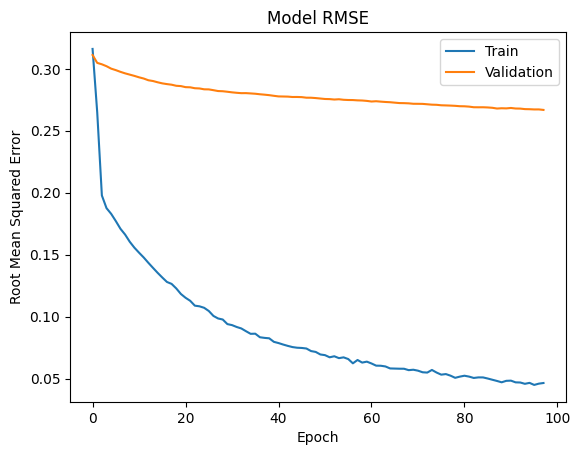

In [167]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

merekomendasikan 10 buku terbaik untuk satu user acak berdasarkan prediksi rating dari model neural network collaborative filtering

In [168]:
user_id = df_collab['user'].sample(1).iloc[0]
books_visited_by_user = df_collab[df_collab['user'] == user_id]['book'].values

books_not_visited = df_collab[~df_collab['book'].isin(books_visited_by_user)]['book'].unique()
books_not_visited = np.array(list(set(books_not_visited)))

books_not_visited_encoded = [[book] for book in books_not_visited]
user_vector = np.array([[user_id]] * len(books_not_visited))
user_book_array = np.hstack((user_vector, books_not_visited_encoded))
ratings = model.predict(user_book_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_encoded_ids = [books_not_visited[x] for x in top_ratings_indices]

recommended_isbns = [encoded_to_book[int(encoded_id)] for encoded_id in recommended_encoded_ids]
recommended_titles = full_data[full_data['ISBN'].isin(recommended_isbns)][['ISBN', 'Book-Title']].drop_duplicates()

# Buku rating tinggi dari user
top_books_user_encoded = df_collab[df_collab['user'] == user_id]\
    .sort_values(by='rating', ascending=False)['book'].head(5).values
top_books_user_isbns = [encoded_to_book[int(book)] for book in top_books_user_encoded]
top_books_user_titles = full_data[full_data['ISBN'].isin(top_books_user_isbns)][['ISBN', 'Book-Title']].drop_duplicates()


print(f"Showing recommendations for user: {encoded_to_user[user_id]}")
print("=" * 30)

print("Books with high ratings from user")
print("-" * 40)
print(top_books_user_titles)

print("-" * 40)
print("Top 10 book recommendations")
print("-" * 40)
print(recommended_titles)

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Showing recommendations for user: 211426
Books with high ratings from user
----------------------------------------
            ISBN                                         Book-Title
229   0345337662                         Interview with the Vampire
790   0060973897                                       Lakota Woman
1715  0140236864                          The Penguin Gandhi Reader
6293  0671617028                                   The Color Purple
6404  080213095X  World of the Buddha: An Introduction to Buddhi...
----------------------------------------
Top 10 book recommendations
----------------------------------------
            ISBN                                         Book-Title
221   0385316895                                  Legacy of Silence
737   0671003364                                             Ransom
1102  0671705091                          A Knight in Shining Armor
1323  0671741039                                     